In [52]:
# パッケージのimport
import math
import random
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from PIL import Image
from torchvision import transforms

%matplotlib inline

In [53]:
# Setup seeds
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)self.last2 = nn.Linear(1024, 1)

In [54]:
input = torch.tensor([[[[1., 1.], [2., 2.]]]])
print("入力データ")
print(input)
print("-----")

print("通常の畳み込み")
m = nn.Conv2d(1, 1, 2, stride=1, bias=False)
m.weight[0, 0, 0, 0] = 1
m.weight[0, 0, 0, 1] = 2
m.weight[0, 0, 1, 0] = 3
m.weight[0, 0, 1, 1] = 4
print("カーネル")
print(m.weight)
print("出力")
print(m(input))

print("-----")
print("転置畳み込み")
m = nn.ConvTranspose2d(1, 1, 2, stride=1, bias=False)
m.weight[0, 0, 0, 0] = 1
m.weight[0, 0, 0, 1] = 2
m.weight[0, 0, 1, 0] = 3
m.weight[0, 0, 1, 1] = 4
print("カーネル")
print(m.weight)
print("出力")
print(m(input))


入力データ
tensor([[[[1., 1.],
          [2., 2.]]]])
-----
通常の畳み込み
カーネル
Parameter containing:
tensor([[[[1., 2.],
          [3., 4.]]]], grad_fn=<CopySlices>)
出力
tensor([[[[17.]]]], grad_fn=<MkldnnConvolutionBackward>)
-----
転置畳み込み
カーネル
Parameter containing:
tensor([[[[1., 2.],
          [3., 4.]]]], grad_fn=<CopySlices>)
出力
tensor([[[[ 1.,  3.,  2.],
          [ 5., 13.,  8.],
          [ 6., 14.,  8.]]]], grad_fn=<SlowConvTranspose2DBackward>)


In [55]:
class Generator(nn.Module):
    def __init__(self, z_dim=20, image_size=64):
        super(Generator, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.ConvTranspose2d(z_dim, image_size * 8, kernel_size=4, stride=1),
            nn.BatchNorm2d(image_size * 8),
            nn.ReLU(inplace=True))
        
        self.layer2 = nn.Sequential(
            nn.ConvTranspose2d(image_size * 8, image_size * 4,
                               kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size * 4),
            nn.ReLU(inplace=True))

        self.layer3 = nn.Sequential(
            nn.ConvTranspose2d(image_size * 4, image_size * 2,
                               kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size * 2),
            nn.ReLU(inplace=True))

        self.layer4 = nn.Sequential(
            nn.ConvTranspose2d(image_size * 2, image_size,
                               kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size),
            nn.ReLU(inplace=True))

        self.last = nn.Sequential(
            nn.ConvTranspose2d(image_size, 1, kernel_size=4,
                               stride=2, padding=1),
            nn.Tanh())
            
    def forward(self, z):
        out = self.layer1(z)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.last(out)

        return out

torch.Size([1, 20, 1, 1])
torch.Size([1, 1, 64, 64])


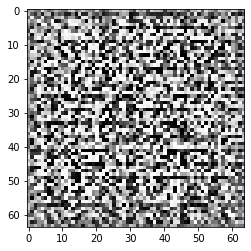

In [56]:
G = Generator(z_dim=20, image_size=64)
input_z = torch.randn(1,20)

input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
print(input_z.size())
fake_images = G(input_z)
print(fake_images.size())
img_transformed = fake_images[0][0].detach().numpy()
plt.imshow(img_transformed, 'gray')
plt.show()

In [57]:
class Discriminator(nn.Module):
    def __init__(self, image_size=64):
        super(Discriminator, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(1, image_size, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(image_size, image_size*2, kernel_size=4,
                      stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))

        self.layer3 = nn.Sequential(
            nn.Conv2d(image_size*2, image_size*4, kernel_size=4,
                      stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))

        self.layer4 = nn.Sequential(
            nn.Conv2d(image_size*4, image_size*8, kernel_size=4,
                      stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))

        self.last = nn.Conv2d(image_size*8, 1, kernel_size=4, stride=1)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.last(out)

        return out

In [58]:
D = Discriminator(image_size=64)
# 偽画像を生成
input_z = torch.randn(1, 20)
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
fake_images = G(input_z)
# print(fake_images.size())

# 偽画像をDに入力
# print(D)
d_out = D(fake_images)

# 出力d_outにSigmoidをかけて0から1に変換
print(nn.Sigmoid()(d_out))

tensor([[[[0.5014]]]], grad_fn=<SigmoidBackward>)


In [59]:
# 正解ラベルを作成
mini_batch_size = 2
label_real = torch.full((mini_batch_size,), 1)

# 偽ラベルを作成
label_fake = torch.full((mini_batch_size,), 0)

criterion = nn.BCEWithLogitsLoss(reduction='mean')


In [60]:
def make_detapath_list():
    
    train_img_list = []
    
    for img_idx in range(200):
        img_path = "./data/img_78/img_7_" + str(img_idx) + '.jpg'
        train_img_list.append(img_path)
        
        img_path = "./data/img_78/img_8_" + str(img_idx) + '.jpg'
        train_img_list.append(img_path)
        
    return train_img_list

In [61]:
class ImageTransform():
    
    def __init__(self, mean, std):
        self.data_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])
        
    def __call__(self, img):
        return self.data_transform(img)

In [62]:
class GAN_Img_Dataset(data.Dataset):
    def __init__(self, file_list, transform):
        self.file_list = file_list
        self.transform = transform
        
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, index):
        img_path = self.file_list[index]
        img = Image.open(img_path)
        
        img_transformed = self.transform(img)
        
        return img_transformed

In [63]:
train_img_list = make_detapath_list()
mean = (0.5,)
std = (0.5,)
train_dataset = GAN_Img_Dataset(
    file_list=train_img_list, transform=ImageTransform(mean, std))

batch_size = 64

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

batch_iterator = iter(train_dataloader)
imgs = next(batch_iterator)
print(imgs.size())

torch.Size([64, 1, 64, 64])


In [64]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        
G.apply(weights_init)
D.apply(weights_init)

print('completed')

completed


In [77]:
def train_model(G, D, dataloader, num_epochs):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print('使用デバイス: ', device)
    
    g_lr, d_lr = 0.0001, 0.0004
    beta1, beta2 = 0.0, 0.9
    g_optimizer = torch.optim.Adam(G.parameters(), g_lr, [beta1, beta2])
    d_optimizer = torch.optim.Adam(D.parameters(), d_lr, [beta1, beta2])

    criterion = nn.BCEWithLogitsLoss(reduction='mean')
    
    z_dim = 20
    mini_batch_size = 64
    
    G.to(device)
    D.to(device)
    
    G.train()
    D.train()
    
    torch.backends.cudnn.benchmark = True
    
    num_train_imgs = len(dataloader.dataset)
    batch_size = dataloader.batch_size
    
    iteration = 1
    logs = []
    
    for epoch in range(num_epochs):
        t_epoch_start = time.time()
        epoch_g_loss = 0.0
        epoch_d_loss = 0.0
        
        print('-------------')
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-------------')
        print('（train）')
        
        for imgs in dataloader:
            if imgs.size()[0] == 1:
                continue
                
            imgs = imgs.to(device)
            
            mini_batch_size = imgs.size()[0]
            label_real = torch.full((mini_batch_size,), 1).to(device)
            label_fake = torch.full((mini_batch_size,), 0).to(device)
            
            d_out_real = D(imgs)
            
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
            fake_images = G(input_z)
            d_out_fake = D(fake_images)
            
            d_loss_real = criterion(d_out_real.view(-1), label_real)
            d_loss_fake = criterion(d_out_fake.view(-1), label_fake)
            d_loss = d_loss_real + d_loss_fake
            
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()
            
            d_loss.backward()
            d_optimizer.step()
            
#             input_z = torch.randn(mini_batch_size, z_dim).to(device)
#             input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
            fake_images = G(input_z)
            d_out_fake = D(fake_images)
            # 誤差を計算
            g_loss = criterion(d_out_fake.view(-1), label_real)

            # バックプロパゲーション
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()
            
            epoch_d_loss += d_loss.item()
            epoch_g_loss += g_loss.item()
            iteration += 1
            
        # epochのphaseごとのlossと正解率
        t_epoch_finish = time.time()
        print('-------------')
        print('epoch {} || Epoch_D_Loss:{:.4f} ||Epoch_G_Loss:{:.4f}'.format(
            epoch, epoch_d_loss/batch_size, epoch_g_loss/batch_size))
        print('timer:  {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
        t_epoch_start = time.time()

    return G, D


In [78]:
# 学習・検証を実行する
# 6分ほどかかる
num_epochs = 200
G_update, D_update = train_model(
    G, D, dataloader=train_dataloader, num_epochs=num_epochs)

使用デバイス:  cuda:0
-------------
Epoch 0/200
-------------
（train）
-------------
epoch 0 || Epoch_D_Loss:0.0059 ||Epoch_G_Loss:0.8701
timer:  0.4869 sec.
-------------
Epoch 1/200
-------------
（train）
-------------
epoch 1 || Epoch_D_Loss:0.0054 ||Epoch_G_Loss:0.7611
timer:  0.4719 sec.
-------------
Epoch 2/200
-------------
（train）
-------------
epoch 2 || Epoch_D_Loss:0.0060 ||Epoch_G_Loss:0.8192
timer:  0.4726 sec.
-------------
Epoch 3/200
-------------
（train）
-------------
epoch 3 || Epoch_D_Loss:0.0039 ||Epoch_G_Loss:0.8016
timer:  0.4495 sec.
-------------
Epoch 4/200
-------------
（train）
-------------
epoch 4 || Epoch_D_Loss:0.0070 ||Epoch_G_Loss:0.8711
timer:  0.4816 sec.
-------------
Epoch 5/200
-------------
（train）
-------------
epoch 5 || Epoch_D_Loss:0.0042 ||Epoch_G_Loss:0.8673
timer:  0.4786 sec.
-------------
Epoch 6/200
-------------
（train）
-------------
epoch 6 || Epoch_D_Loss:0.0064 ||Epoch_G_Loss:0.7826
timer:  0.4730 sec.
-------------
Epoch 7/200
-------------

-------------
epoch 60 || Epoch_D_Loss:0.0061 ||Epoch_G_Loss:0.6922
timer:  0.3912 sec.
-------------
Epoch 61/200
-------------
（train）
-------------
epoch 61 || Epoch_D_Loss:0.0061 ||Epoch_G_Loss:0.6314
timer:  0.3943 sec.
-------------
Epoch 62/200
-------------
（train）
-------------
epoch 62 || Epoch_D_Loss:0.0066 ||Epoch_G_Loss:0.7469
timer:  0.3979 sec.
-------------
Epoch 63/200
-------------
（train）
-------------
epoch 63 || Epoch_D_Loss:0.0065 ||Epoch_G_Loss:0.5593
timer:  0.3896 sec.
-------------
Epoch 64/200
-------------
（train）
-------------
epoch 64 || Epoch_D_Loss:0.0059 ||Epoch_G_Loss:0.6248
timer:  0.3961 sec.
-------------
Epoch 65/200
-------------
（train）
-------------
epoch 65 || Epoch_D_Loss:0.0059 ||Epoch_G_Loss:0.6606
timer:  0.3904 sec.
-------------
Epoch 66/200
-------------
（train）
-------------
epoch 66 || Epoch_D_Loss:0.0086 ||Epoch_G_Loss:0.5978
timer:  0.3942 sec.
-------------
Epoch 67/200
-------------
（train）
-------------
epoch 67 || Epoch_D_Loss:0.

-------------
epoch 120 || Epoch_D_Loss:0.0082 ||Epoch_G_Loss:0.6284
timer:  0.3808 sec.
-------------
Epoch 121/200
-------------
（train）
-------------
epoch 121 || Epoch_D_Loss:0.0106 ||Epoch_G_Loss:0.5156
timer:  0.3859 sec.
-------------
Epoch 122/200
-------------
（train）
-------------
epoch 122 || Epoch_D_Loss:0.0065 ||Epoch_G_Loss:0.4957
timer:  0.3824 sec.
-------------
Epoch 123/200
-------------
（train）
-------------
epoch 123 || Epoch_D_Loss:0.0064 ||Epoch_G_Loss:0.5555
timer:  0.3807 sec.
-------------
Epoch 124/200
-------------
（train）
-------------
epoch 124 || Epoch_D_Loss:0.0063 ||Epoch_G_Loss:0.5750
timer:  0.3836 sec.
-------------
Epoch 125/200
-------------
（train）
-------------
epoch 125 || Epoch_D_Loss:0.0069 ||Epoch_G_Loss:0.5359
timer:  0.3825 sec.
-------------
Epoch 126/200
-------------
（train）
-------------
epoch 126 || Epoch_D_Loss:0.0068 ||Epoch_G_Loss:0.5870
timer:  0.3811 sec.
-------------
Epoch 127/200
-------------
（train）
-------------
epoch 127 || 

-------------
epoch 179 || Epoch_D_Loss:0.0067 ||Epoch_G_Loss:0.5946
timer:  0.3815 sec.
-------------
Epoch 180/200
-------------
（train）
-------------
epoch 180 || Epoch_D_Loss:0.0073 ||Epoch_G_Loss:0.5325
timer:  0.3826 sec.
-------------
Epoch 181/200
-------------
（train）
-------------
epoch 181 || Epoch_D_Loss:0.0071 ||Epoch_G_Loss:0.5485
timer:  0.3809 sec.
-------------
Epoch 182/200
-------------
（train）
-------------
epoch 182 || Epoch_D_Loss:0.0076 ||Epoch_G_Loss:0.5557
timer:  0.3813 sec.
-------------
Epoch 183/200
-------------
（train）
-------------
epoch 183 || Epoch_D_Loss:0.0103 ||Epoch_G_Loss:0.4975
timer:  0.3802 sec.
-------------
Epoch 184/200
-------------
（train）
-------------
epoch 184 || Epoch_D_Loss:0.0070 ||Epoch_G_Loss:0.5207
timer:  0.3828 sec.
-------------
Epoch 185/200
-------------
（train）
-------------
epoch 185 || Epoch_D_Loss:0.0063 ||Epoch_G_Loss:0.5709
timer:  0.3823 sec.
-------------
Epoch 186/200
-------------
（train）
-------------
epoch 186 || 

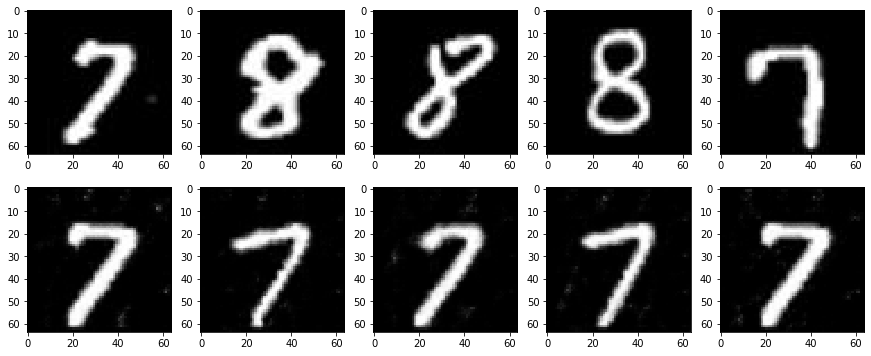

In [79]:
# 生成画像と訓練データを可視化する
# 本セルは良い感じの画像が生成されるまで、何度も実行し直しています。

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 入力の乱数生成
batch_size = 8
z_dim = 20
fixed_z = torch.randn(batch_size, z_dim)
fixed_z = fixed_z.view(fixed_z.size(0), fixed_z.size(1), 1, 1)

# 画像生成
fake_images = G_update(fixed_z.to(device))

# 訓練データ
batch_iterator = iter(train_dataloader)  # イテレータに変換
imges = next(batch_iterator)  # 1番目の要素を取り出す


# 出力
fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):
    # 上段に訓練データを
    plt.subplot(2, 5, i+1)
    plt.imshow(imges[i][0].cpu().detach().numpy(), 'gray')

    # 下段に生成データを表示する
    plt.subplot(2, 5, 5+i+1)
    plt.imshow(fake_images[i][0].cpu().detach().numpy(), 'gray')